# Reference java implementation of parsing
```java

try (BufferedReader br =
    new BufferedReader(new FileReader(new File(Filesystem.getDeployDirectory(), "launcherData.csv")))
) {
    // The first line is CSV labels
    @SuppressWarnings("unused")
    String labels = br.readLine();

    String line;
    while ((line = br.readLine()) != null) {
        String[] parts = line.split(",");
        lookupTable.add(new LauncherLookupValue(
            Float.parseFloat(parts[0]),
            Float.parseFloat(parts[1]),
            new LauncherState(
                Float.parseFloat(parts[2]),
                Float.parseFloat(parts[3])
            )
        ));
    }
}
```

In [83]:
lookupTable = []

with open("./launcherData.csv", 'r', encoding='UTF-8') as file:
    file.readline()
    while line := file.readline():
        parts = line.rstrip().split(',')
        lookupTable.append({
            "x": float(parts[0]),
            "y": float(parts[1]),
            "speed": float(parts[2]),
            "angle": float(parts[3])
        })

print(lookupTable)

[{'x': 15.09168816, 'y': 5.542706763, 'speed': 3560.0, 'angle': 59.2}, {'x': 14.78555132, 'y': 5.547281643, 'speed': 3600.0, 'angle': 54.1}, {'x': 14.15510591, 'y': 5.646183256, 'speed': 4300.0, 'angle': 45.1}, {'x': 13.60403794, 'y': 5.551537765, 'speed': 4980.0, 'angle': 35.85}, {'x': 12.61115556, 'y': 5.400385394, 'speed': 5530.0, 'angle': 23.25}, {'x': 11.2309524, 'y': 6.210100763, 'speed': 4500.0, 'angle': 23.25}, {'x': 15.97014558, 'y': 6.514427714, 'speed': 3300.0, 'angle': 57.1}, {'x': 15.97014558, 'y': 4.148696897, 'speed': 3300.0, 'angle': 57.1}, {'x': 15.41639615, 'y': 5.888130097, 'speed': 3300.0, 'angle': 55.45}, {'x': 15.41639615, 'y': 4.774994515, 'speed': 3300.0, 'angle': 55.45}, {'x': 14.64279474, 'y': 6.933005401, 'speed': 4140.0, 'angle': 43.0}, {'x': 14.64279474, 'y': 3.73011921, 'speed': 4140.0, 'angle': 43.0}, {'x': 14.32163299, 'y': 4.129386067, 'speed': 4420.0, 'angle': 39.25}, {'x': 14.32163299, 'y': 6.533738544, 'speed': 4420.0, 'angle': 39.25}, {'x': 14.87465

# Reference Java interplotation implementation
```java

    LauncherLookupValue closestPoints[] = new LauncherLookupValue[4];
    for (int i = 0; i < 4; i++) {
        closestPoints[i] = lookupTable.get(0);
    }
    double closestDistances[] = new double[4];
    for (int i = 0; i < 4; i++) {
        closestDistances[i] = Double.MAX_VALUE;
    }

    for (LauncherLookupValue value : lookupTable) {
        double distance = currentTranslation.getDistance(new Translation2d(value.x, value.y));
        for (int i = 0; i < 4; i++) {
            if (distance < closestDistances[i]) {
                closestDistances[i] = distance;
                closestPoints[i] = value;
                break;
            }
        }
    }

    // Interpolate between the 4 closest points using bilinear interpolation

    // interpolated value = (1 - alpha) * ((1 - beta) * p1 + beta * p2) + alpha * ((1 - beta) * p3 + beta * p4)
    // Source: https://stackoverflow.com/questions/23920976/bilinear-interpolation-with-non-aligned-input-points

    double alpha = (currentTranslation.getX() - closestPoints[0].x) / (closestPoints[1].x - closestPoints[0].x);
    double beta = (currentTranslation.getY() - closestPoints[0].y) / (closestPoints[2].y - closestPoints[0].y);

    LauncherState p1 = closestPoints[0].state;
    LauncherState p2 = closestPoints[1].state;
    LauncherState p3 = closestPoints[2].state;
    LauncherState p4 = closestPoints[3].state;

    double speed = (1 - alpha) * ((1 - beta) * p1.speed + beta * p2.speed) + alpha * ((1 - beta) * p3.speed + beta * p4.speed);
    double angleDegrees = (1 - alpha) * ((1 - beta) * p1.angleDegrees + beta * p2.angleDegrees) + alpha * ((1 - beta) * p3.angleDegrees + beta * p4.angleDegrees);

    return new LauncherState(speed, angleDegrees);
```

In [ ]:
%matplotlib inline

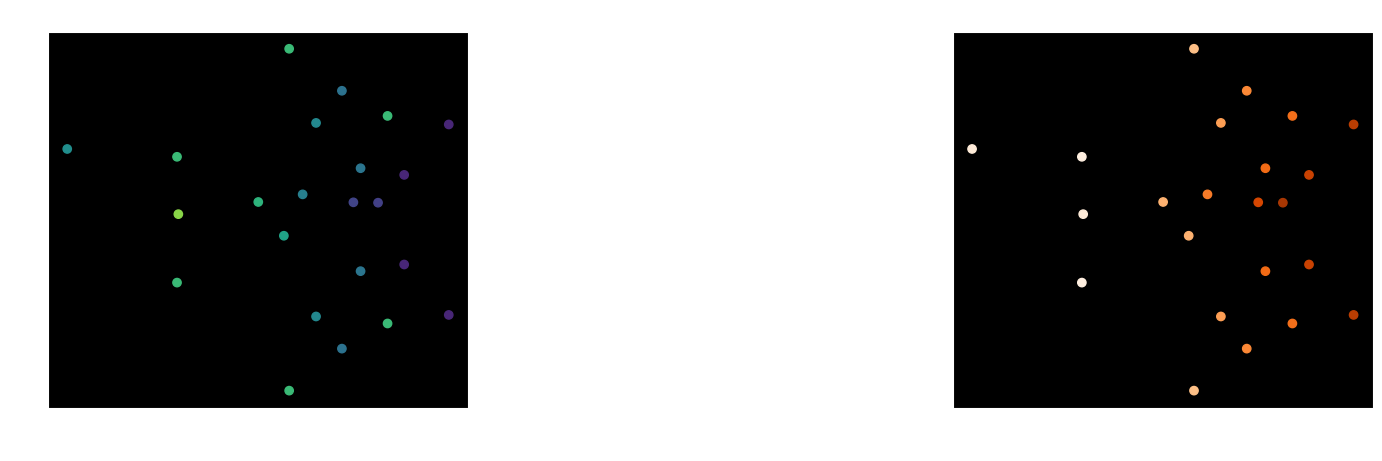

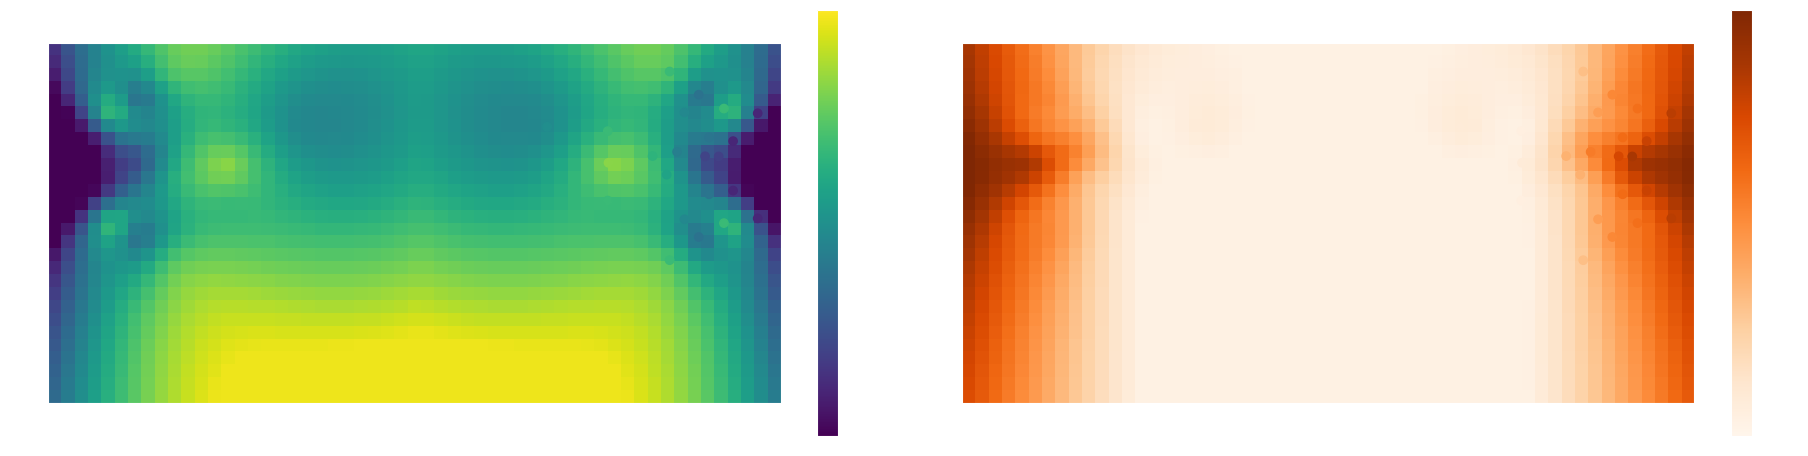

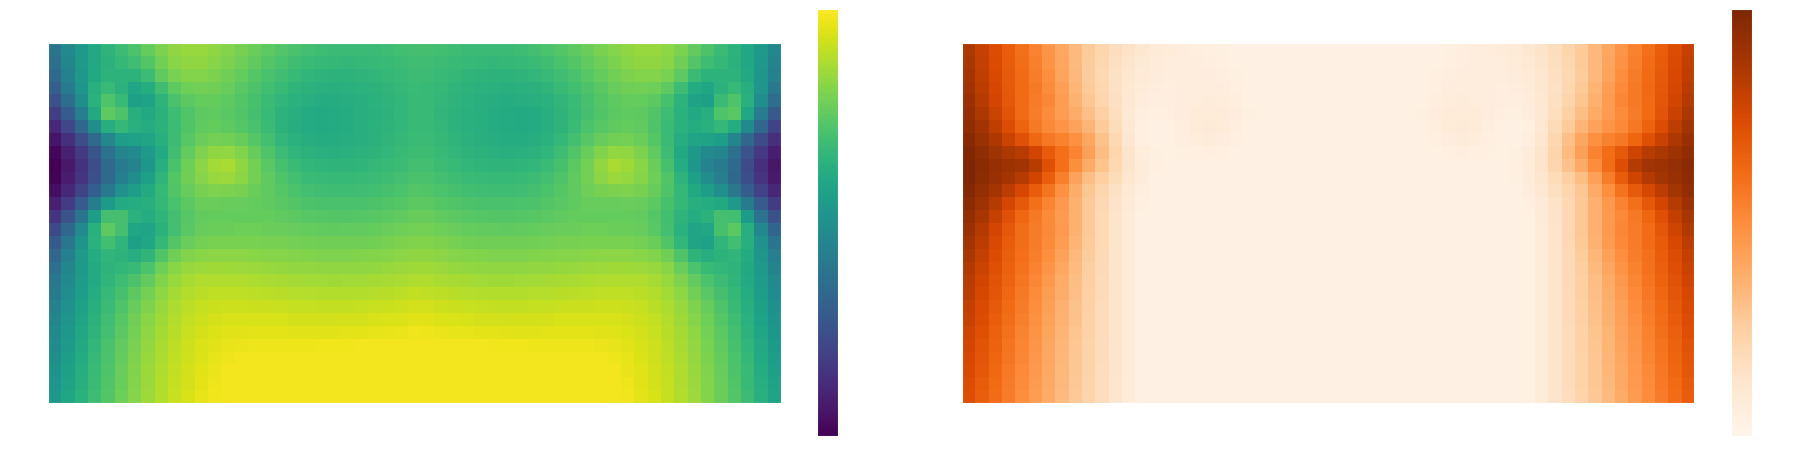

In [129]:
# We temporarily use scipy's CloughTocher2DInterpolator to interpolate the data
from scipy.interpolate import RBFInterpolator
import numpy as np

xpos = np.array([p["x"] for p in lookupTable])
ypos = np.array([p["y"] for p in lookupTable])
speed = np.array([p["speed"] for p in lookupTable])
angle = np.array([p["angle"] for p in lookupTable])

field_x_size = 16.48459999 # Length
field_y_size = 8.102599929 # Width

# Shape xpos and ypos into an array of (x, y) pairs
xy = np.column_stack((xpos, ypos))

# Settings that make sure we always go through the points
speed_interpolator = RBFInterpolator(xy, speed)
angle_interpolator = RBFInterpolator(xy, angle)

def get_point_value(x, y):
    if(x < field_x_size / 2): x = field_x_size - x
    speed = speed_interpolator(np.array([[x, y]]))[0]
    speed = max(0, min(6000, speed))
    angle = angle_interpolator(np.array([[x, y]]))[0]
    angle = max(21, min(80, angle))
    return speed, angle




# Visualize the output.
# First, plot every point in the lookup table, coloring the point based on their speed
# Next, find the value for every square in a grid and plot it
import matplotlib.pyplot as plt

# Function so we can return for easy testing
def run(points=True, grid=True, save=False, use_speed=True):
    speed = [p["speed"] for p in lookupTable]
    angle = [p["angle"] for p in lookupTable]

    minspeed = min(speed) * 0.9
    maxspeed = max(speed) * 1.1
    minangle = min(angle) * 0.9
    maxangle = max(angle) * 1.1

    if(points):
        x = [p["x"] for p in lookupTable]
        y = [p["y"] for p in lookupTable]
        if(use_speed):
            plt.scatter(x, y, c=speed, cmap='viridis', vmin=minspeed, vmax=maxspeed)
        else:
            plt.scatter(x, y, c=angle, cmap='Oranges', vmin=minangle, vmax=maxangle)

    if(grid or save):
        # Create a grid of points
        minx = 0
        maxx = field_x_size
        miny = 0
        maxy = field_y_size

        def frange(x, y, jump):
            while x < y:
                yield x
                x += jump

        gridsize = 0.3
        gridx = [i for i in frange(minx, maxx, gridsize)]
        gridy = [i for i in frange(miny, maxy, gridsize)]
        
        save_data = f"{len(gridx)}:{len(gridy)}:{round(minx * 1000) / 1000}:{round(maxx * 1000) / 1000}:{round(miny * 1000) / 1000}:{round(maxy * 1000) / 1000}\n"

        grid_data = []

        for y in gridy:
            grid_data.append([])
            for x in gridx:
                speed, angle = get_point_value(x, y)
                if(use_speed):
                    grid_data[-1].append(speed)
                    if not points:
                        if speed < minspeed: minspeed = speed
                        if speed > maxspeed: maxspeed = speed
                else:
                    grid_data[-1].append(angle)
                    if not points:
                        if angle < minangle: minangle = angle
                        if angle > maxangle: maxangle = angle
                
                if(save):
                    save_data += f"{round(speed)},{round(angle * 100) / 100}\n"

        if(save):
            with open("../src/main/deploy/launcherData.txt", 'w') as file:
                file.write(save_data)

        if(use_speed):
            plt.imshow(grid_data, extent=(minx, maxx, miny, maxy), origin='lower', cmap='viridis', alpha=1.0, aspect='auto', vmin=minspeed, vmax=maxspeed)
            plt.colorbar(label="Speed (m/s)")
        else:
            plt.imshow(grid_data, extent=(minx, maxx, miny, maxy), origin='lower', cmap='Oranges', alpha=1.0, aspect='auto', vmin=minangle, vmax=maxangle)
            plt.colorbar(label="Angle (degrees)")
    
    plt.xlabel("Field X (m)")
    plt.ylabel("Field Y (m)")

    # Set the aspect of the plot to be equal
    plt.gca().set_aspect('equal', adjustable='box')

# Subblots: just points, just grid, both
plt.style.use('dark_background')

plt.figure(figsize=(18, 4.5), layout='constrained', frameon=False, dpi=100)

plt.subplot(1, 2, 1)
plt.title("Collected Points (Speed)")
run(points=True, grid=False, use_speed=True, save=False)

plt.subplot(1, 2, 2)
plt.title("Collected Points (Angle)")
run(points=True, grid=False, use_speed=False, save=False)

plt.figure(figsize=(18, 4.5), layout='constrained', frameon=False, dpi=100)

plt.subplot(1, 2, 1)
plt.title("Extrapolated and Interpolated Launcher Grid and Collected Points (Speed)")
run(points=True, grid=True, use_speed=True, save=False)

plt.subplot(1, 2, 2)
plt.title("Extrapolated and Interpolated Launcher Grid and Collected Points (Angle)")
run(points=True, grid=True, use_speed=False, save=False)
   
plt.show()

plt.figure(figsize=(18, 4.5), layout='constrained', frameon=False, dpi=100)
plt.subplot(1, 2, 1)
plt.title("Extrapolated and Interpolated Launcher Grid (Speed)")
run(points=False, grid=True, use_speed=True, save=False)

plt.subplot(1, 2, 2)
plt.title("Extrapolated and Interpolated Launcher Grid (Angle)")
run(points=False, grid=True, use_speed=False, save=True)

plt.show()

In [29]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri

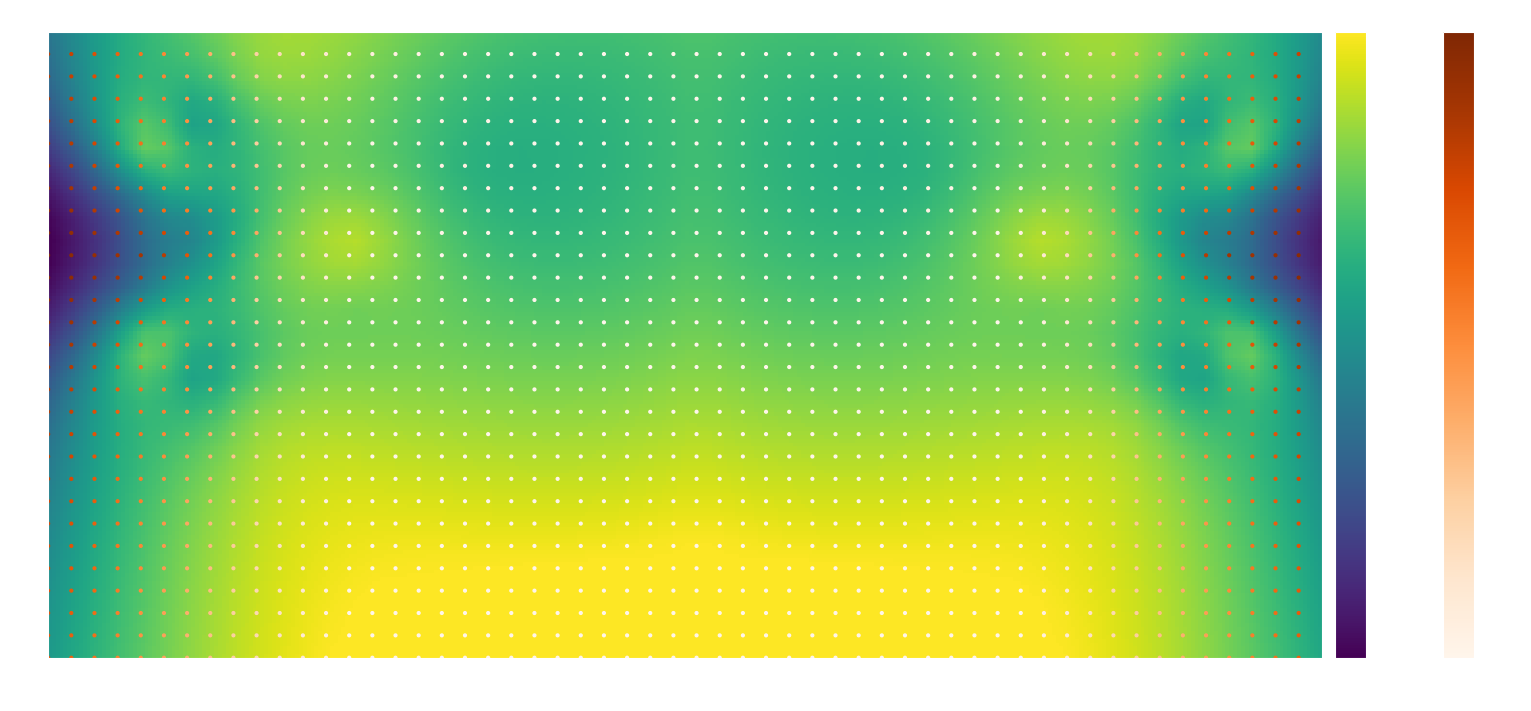

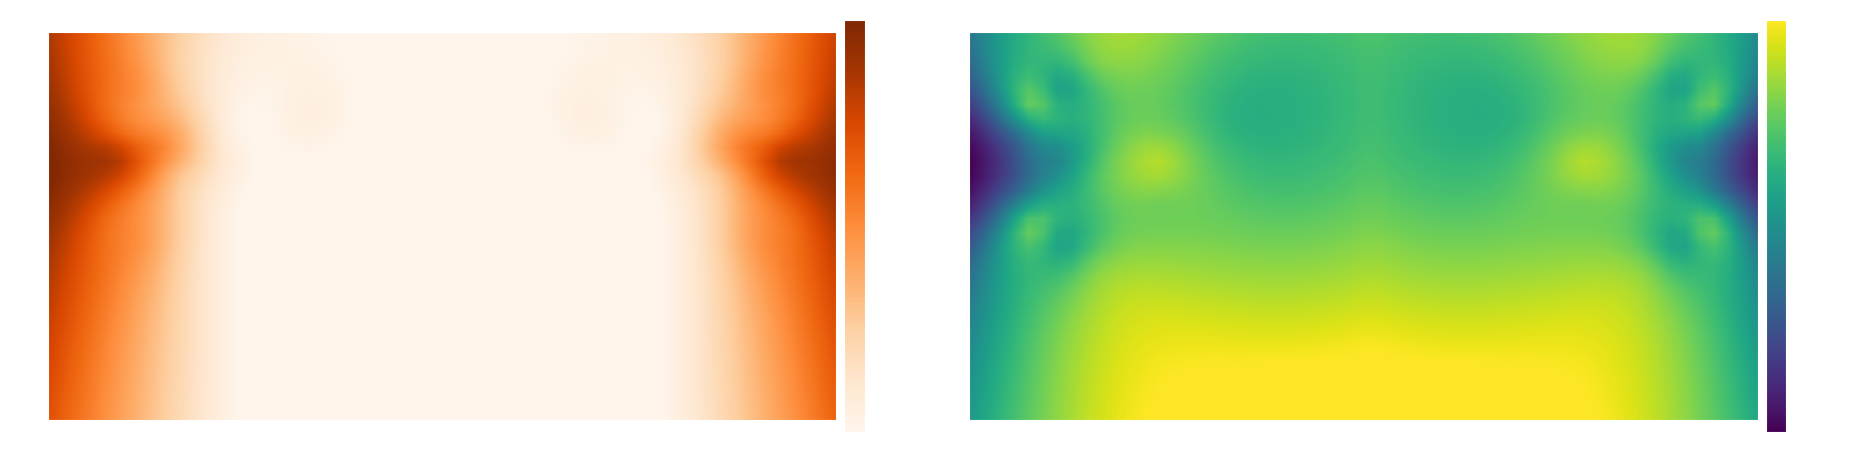

In [127]:
import matplotlib.pyplot as plt

launcherStateGrid = []
grid_size_x = 0
grid_size_y = 0
minx = 0
maxx = 0
miny = 0
maxy = 0

with open("../src/main/deploy/launcherData.csv", 'r', encoding='UTF-8') as file:
  sizes = file.readline().rstrip().split(":")
  grid_x_size = int(sizes[0])
  grid_y_size = int(sizes[1])
  minx = float(sizes[2])
  maxx = float(sizes[3])
  miny = float(sizes[4])
  maxy = float(sizes[5])

  while line := file.readline():
    parts = line.rstrip().split(",")
    speed = float(parts[0])
    angle = float(parts[1])
    launcherStateGrid.append((speed, angle))

def getGridPoint(x, y):
  x = min(max(x, 0), grid_x_size - 1)
  y = min(max(y, 0), grid_y_size - 1)

  return launcherStateGrid[y * grid_x_size + x]

def get_launcher_state(x, y):
  import math

  # We find the 4 closest points in the grid and bilinearly interpolate between them
  x1 = math.floor((x - minx) / (maxx - minx) * (grid_x_size - 1))
  y1 = math.floor((y - miny) / (maxy - miny) * (grid_y_size - 1))
  x2 = x1 + 1
  y2 = y1 + 1

  xfrac = (x - minx) / (maxx - minx) * (grid_x_size - 1) - x1
  yfrac = (y - miny) / (maxy - miny) * (grid_y_size - 1) - y1

  p1 = getGridPoint(x1, y1)
  p2 = getGridPoint(x2, y1)
  p3 = getGridPoint(x1, y2)
  p4 = getGridPoint(x2, y2)

  speed = (1 - xfrac) * (1 - yfrac) * p1[0] + xfrac * (1 - yfrac) * p2[0] + (1 - xfrac) * yfrac * p3[0] + xfrac * yfrac * p4[0]
  angle = (1 - xfrac) * (1 - yfrac) * p1[1] + xfrac * (1 - yfrac) * p2[1] + (1 - xfrac) * yfrac * p3[1] + xfrac * yfrac * p4[1]

  return (speed, angle)

def draw_processed(points=False, angle_grid=False, grid=False):
  if points and not angle_grid:
    # Scatter plot for every point on the launcherStateGrid
    x = [minx + (maxx - minx) / grid_x_size * (i % grid_x_size) for i in range(len(launcherStateGrid))]
    y = [miny + (maxy - miny) / grid_y_size * (i // grid_x_size) for i in range(len(launcherStateGrid))]
    angle = [p[1] for p in launcherStateGrid]
    plt.scatter(x, y, c=angle, cmap='Oranges', alpha=1.0, s=4)
    plt.colorbar(label="Angle (degrees)", pad=0.01)

  if grid or angle_grid:
    def frange(x, y, jump):
        while x < y:
            yield x
            x += jump

    gridsize = 0.05
    gridx = [i for i in frange(minx, maxx, gridsize)]
    gridy = [i for i in frange(miny, maxy, gridsize)]
    
    grid_data_speed = []
    grid_data_angle = []

    for y in gridy:
        grid_data_speed.append([])
        grid_data_angle.append([])
        for x in gridx:
            speed, angle = get_launcher_state(x, y)
            grid_data_speed[-1].append(speed)
            grid_data_angle[-1].append(angle)

    if grid:
      plt.imshow(grid_data_speed, extent=(minx, maxx, miny, maxy), origin='lower', cmap='viridis', aspect='auto')

    if angle_grid:
      plt.imshow(grid_data_angle, extent=(minx, maxx, miny, maxy), origin='lower', cmap='Oranges', aspect='auto')

    plt.colorbar(label="Speed (m/s)", pad=0.01)


  plt.xlabel("Field X (m)")
  plt.ylabel("Field Y (m)")

  # Set the aspect of the plot to be equal
  plt.gca().set_aspect('equal', adjustable='box')

plt.style.use('dark_background')

plt.figure(figsize=(15, 7), layout='constrained', frameon=False, dpi=100)
plt.title("Launcher State (Speed and Angle), Robot-Side Processing Results")
draw_processed(points=True, grid=True)

plt.show()

plt.figure(figsize=(18.5, 4.5), layout='constrained', frameon=False, dpi=100)

plt.subplot(1, 2, 1)
plt.title("Launcher State (Angle Only), Robot-Side Processing Results")
draw_processed(points=True, angle_grid=True, grid=False)

plt.subplot(1, 2, 2)
plt.title("Launcher State (Speed Only), Robot-Side Processing Results")
draw_processed(points=False, grid=True)

plt.show()

# 